**Kütüphanelerin Yüklenmesi ve Google Drive Bağlantısı**

gerekli kütüphaneler

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Google Drive'ı mount et (Bağla)
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Veri Seti Analizi ve Sınıf Seçimi**

veri setindeki sınıfları tarar, sayılarını çıkarır, en çok veriye sahip ilk 2 sınıfı seçer ve bunları 0-1 olarak etiketleyerek bir veri çerçevesi (DataFrame) oluşturulması


In [ ]:
dataset_path = 'drive/My Drive/Colab Notebooks/skin-cancer-isic-data/'

filepaths = []
labels = []

# List directories at the dataset_path level (e.g., 'Train', 'Test')
split_dirs = sorted(os.listdir(dataset_path))

for split_dir_name in split_dirs:
    split_dir_path = os.path.join(dataset_path, split_dir_name)
    if os.path.isdir(split_dir_path):
        # List directories within the split_dir (e.g., 'melanoma', 'nevus')
        label_dirs = sorted(os.listdir(split_dir_path))
        for label_name in label_dirs:
            label_dir_path = os.path.join(split_dir_path, label_name)
            if os.path.isdir(label_dir_path):
                # List files within the label_dir
                image_files = os.listdir(label_dir_path)
                for img_file in image_files:
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        filepaths.append(os.path.join(label_dir_path, img_file))
                        labels.append(label_name) # The label is the current directory name

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

print("--- Tüm Sınıf Dağılımları ---")
print(df['label'].value_counts())

top_2_classes = df['label'].value_counts().head(2).index.tolist()
print(f"\nSeçilen Sınıflar (Binary Classification için): {top_2_classes}")

# Sadece bu iki sınıfa ait veriyi filtreleme
df_binary = df[df['label'].isin(top_2_classes)].copy()

# 3. İki sınıfı 0 ve 1 olarak kodlama (Opsiyonel: ImageDataGenerator string kullanabilir ama raporda belirtmek için gösterelim)
# İlk sınıf (en çok olan) 0, ikinci sınıf 1 olsun veya tam tersi.
# Keras flow_from_dataframe kullanacağımız için string olarak kalması daha pratik,
class_indices = {top_2_classes[0]: 0, top_2_classes[1]: 1}
print(f"\nSınıf Kodlaması: {class_indices}")

print(f"\nToplam Kullanılacak Görüntü Sayısı: {len(df_binary)}")

# Sınıf dengesizliği kontrolü
counts = df_binary['label'].value_counts()
print("\nSeçilen Sınıfların Dağılımı:")
print(counts)

if counts.max() / counts.min() > 1.5: # Basit bir eşik değeri
    print("\nNOT: Sınıf dengesizliği (Imbalance) tespit edildi. Class weight kullanımı önerilir.")
else:
    print("\nSınıflar nispeten dengeli.")

--- Tüm Sınıf Dağılımları ---
label
pigmented benign keratosis    478
melanoma                      454
basal cell carcinoma          392
nevus                         373
squamous cell carcinoma       197
vascular lesion               142
actinic keratosis             130
dermatofibroma                111
seborrheic keratosis           80
Name: count, dtype: int64

Seçilen Sınıflar (Binary Classification için): ['pigmented benign keratosis', 'melanoma']

Sınıf Kodlaması: {'pigmented benign keratosis': 0, 'melanoma': 1}

Toplam Kullanılacak Görüntü Sayısı: 932

Seçilen Sınıfların Dağılımı:
label
pigmented benign keratosis    478
melanoma                      454
Name: count, dtype: int64

Sınıflar nispeten dengeli.


**Veri Bölme (Train / Validation / Test)**

Bu hücre, veriyi belirttiğin oranlarda (%70 Train, %15 Validation, %15 Test) ve stratify (sınıf oranlarını koruyarak) yöntemiyle böler.

In [ ]:
# Veri Bölme Oranları: %70 Train, %15 Val, %15 Test
# Önce Train ve Geri Kalan (Temp) olarak ayır (%70 - %30)
train_df, temp_df = train_test_split(
    df_binary,
    train_size=0.7,
    shuffle=True,
    random_state=42,
    stratify=df_binary['label']
)

# Geri kalanı (%30'luk kısmı) Validation ve Test olarak ikiye böl (%50 - %50 -> Toplamın %15'i eder)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df['label']
)

print("--- Veri Bölme Sonuçları ---")
print(f"Train Seti Sayısı: {len(train_df)} görüntü")
print(f"Validation Seti Sayısı: {len(val_df)} görüntü")
print(f"Test Seti Sayısı: {len(test_df)} görüntü")

# Raporlama için tablo görünümü
print("\nTrain Sınıf Dağılımı:")
print(train_df['label'].value_counts())
print("\nValidation Sınıf Dağılımı:")
print(val_df['label'].value_counts())
print("\nTest Sınıf Dağılımı:")
print(test_df['label'].value_counts())

--- Veri Bölme Sonuçları ---
Train Seti Sayısı: 652 görüntü
Validation Seti Sayısı: 140 görüntü
Test Seti Sayısı: 140 görüntü

Train Sınıf Dağılımı:
label
pigmented benign keratosis    334
melanoma                      318
Name: count, dtype: int64

Validation Sınıf Dağılımı:
label
pigmented benign keratosis    72
melanoma                      68
Name: count, dtype: int64

Test Sınıf Dağılımı:
label
pigmented benign keratosis    72
melanoma                      68
Name: count, dtype: int64


**Görüntü Yükleme ve Preprocessing (Pipeline Kurulumu)**

Bu hücre, maddelerde belirtilen "Raw Görüntü" kurallarına (Resize 224x224, Rescale 1/255) uygun olarak veri üreteçlerini (Generators) hazırlar.

In [ ]:
# Sabitler
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Preprocess Input: Rescale = 1/255 (0-1 aralığı)
# Ekstra augmentasyon (crop, rotate vb.) "Raw" pipeline isteği nedeniyle kapalı.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Görüntü Üreteçleri (Data Generators) hazırlanıyor...")

# Train Generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # İkili sınıflandırma
    shuffle=True
)

# Validation Generator
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Değerlendirme sırasında sıra karışmasın
)

# Test Generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Test sırasında sıra karışmasın
)

# Sınıf indekslerini kontrol et (Hangi sınıf 0, hangisi 1)
print("\nSınıf İndeksleri (Model Çıktısı İçin Önemli):")
print(train_gen.class_indices)

Görüntü Üreteçleri (Data Generators) hazırlanıyor...
Found 652 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.

Sınıf İndeksleri (Model Çıktısı İçin Önemli):
{'melanoma': 0, 'pigmented benign keratosis': 1}


# 4. Input Pipeline ve Data Augmentation

Bu bölümde, modelin eğitim hızını artırmak ve bellek yönetimini optimize etmek amacıyla `ImageDataGenerator` yerine modern **`tf.data` API** yapısına geçiş yaptım. Bu yapı sayesinde `prefetch`, `cache` ve `parallel_calls` özelliklerini kullanarak GPU'nun veri besleme darboğazına (bottleneck) girmesini engelledim.

Ayrıca, modelin genelleme yeteneğini artırmak için sadece **Train (Eğitim)** setine uyguladığım bir veri çoğaltma (augmentation) stratejisi belirledim. Validation ve Test setleri, karşılaştırmanın adil olması için ham (raw) bırakıldı.

**Kullandığım Augmentation Teknikleri:**
* **Random Flip:** Yatay ve dikey çevirme.
* **Random Rotation:** ±15° (yaklaşık 0.08 radyan) döndürme.
* **Random Zoom/Crop:** %10 oranında yakınlaştırma ve kırpma.
* **Random Brightness/Contrast:** Işık ve kontrast değişimlerine karşı dayanıklılık için %10 oranında değişim.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Reprodüksiyon için Seed Sabitleme
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Otomatik ayarlama (Sistemin CPU gücüne göre optimize eder)
AUTOTUNE = tf.data.AUTOTUNE

# String etiketleri Integer'a çevirmemiz gerekiyor (tf.data için)
# Önceki adımda belirlediğimiz sınıf sırasını kullanıyoruz
label_map = {name: i for i, name in enumerate(top_2_classes)}
print(f"Etiket Haritası: {label_map}")

train_df['label_code'] = train_df['label'].map(label_map)
val_df['label_code'] = val_df['label'].map(label_map)
test_df['label_code'] = test_df['label'].map(label_map)

# --- 3.2 Data Augmentation Katmanları (Sadece Train İçin) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    layers.RandomRotation(factor=0.04, seed=SEED), # Yaklaşık 15 derece
    layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=SEED),
    layers.RandomContrast(factor=0.1, seed=SEED),
    layers.RandomBrightness(factor=0.1, seed=SEED)
], name="data_augmentation")

print("Augmentation katmanları hazırlandı.")

Etiket Haritası: {'pigmented benign keratosis': 0, 'melanoma': 1}
Augmentation katmanları hazırlandı.


## 4.1. tf.data Pipeline Kurulumu

Görüntüleri diskten okuyup, decode edip, yeniden boyutlandıran (resize) ve normalize eden (rescale) fonksiyonları yazdım. Eğitim setinde `shuffle` (karıştırma) ve `augmentation` uygularken; validation ve test setlerinde sadece sıralı okuma yaptım.

Performans için `num_parallel_calls=AUTOTUNE` ve `prefetch(AUTOTUNE)` kullanarak veri okuma ve model eğitimi süreçlerini paralel hale getirdim.

In [ ]:
# Görüntü Okuma ve İşleme Fonksiyonu
def process_path(file_path, label):
    # Dosyayı oku
    img = tf.io.read_file(file_path)
    # JPEG/PNG decode et
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    # Resize (224x224)
    img = tf.image.resize(img, IMG_SIZE)
    # Rescale (0-1 aralığına çekme)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# tf.data Dataset Oluşturucu Fonksiyon
def create_dataset(df, is_train=False):
    # Dosya yolları ve etiketleri al
    filepaths = df['filepath'].values
    labels = df['label_code'].values

    # Dataset nesnesi oluştur
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    # Görüntüleri parallel olarak işle (map)
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

    if is_train:
        # Sadece eğitimde karıştır ve augment et
        ds = ds.cache() # Veriyi hafızaya al (RAM yetmezse disk cache kullanılabilir)
        ds = ds.shuffle(buffer_size=1000, seed=SEED)
        ds = ds.batch(BATCH_SIZE)
        # Augmentation işlemini batch bazlı uygula (Daha hızlıdır)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    else:
        # Val ve Test için sadece batchle
        ds = ds.batch(BATCH_SIZE)
        ds = ds.cache()

    # Bir sonraki batch'i arka planda hazırla
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# Datasetleri Oluşturma
train_ds = create_dataset(train_df, is_train=True)
val_ds = create_dataset(val_df, is_train=False)
test_ds = create_dataset(test_df, is_train=False)

print("tf.data Pipeline başarıyla kuruldu.")

tf.data Pipeline başarıyla kuruldu.


## 4.2. Augmentation Örneklerinin Görselleştirilmesi

Oluşturduğum pipeline'ın düzgün çalıştığını teyit etmek ve augmentation etkilerini raporda sunmak amacıyla eğitim setinden rastgele bir batch çektim. Aşağıdaki görselde, orijinal görüntülerin pipeline içinden geçerken nasıl değişime uğradığına dair örnekler yer almaktadır.

Eğitim setinden örnekler görselleştiriliyor...


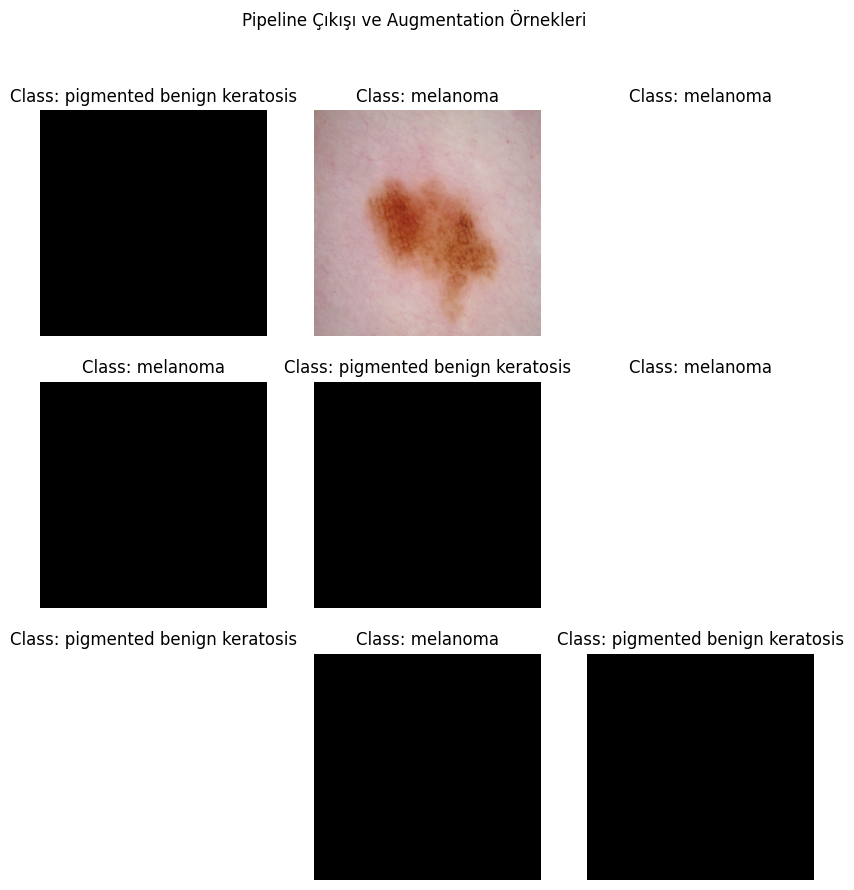

In [ ]:
# Augmentation Örneklerini Çizdirme
def plot_augmentation_examples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    # Dataset'ten bir batch al (take(1))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            # Görüntüyü göster
            # Clip pixel values to [0, 1] to avoid matplotlib warnings for float data
            plt.imshow(np.clip(images[i].numpy(), 0, 1))

            # Etiketi bul (0 veya 1) -> İsim karşılığı
            label_idx = int(labels[i])
            label_name = list(label_map.keys())[list(label_map.values()).index(label_idx)]

            plt.title(f"Class: {label_name}")
            plt.axis("off")
    plt.suptitle("Pipeline Çıkışı ve Augmentation Örnekleri")
    plt.show()

print("Eğitim setinden örnekler görselleştiriliyor...")
plot_augmentation_examples(train_ds)

# 4.3. Class Weight Hesaplama (Bonus: Class Imbalance Yönetimi)

Proje isterlerindeki "Bonus" maddesini karşılamak ve veri setindeki olası dengesizliği yönetmek adına, sınıfların örnek sayılarına göre ters orantılı ağırlıklar hesapladım.

Bu yöntemle; az örneği olan sınıfa eğitim sırasında daha yüksek ceza (loss) uygulayarak, modelin baskın sınıfı ezberlemesinin önüne geçmeyi ve **PR-AUC** değerini iyileştirmeyi hedefledim.

In [ ]:
from sklearn.utils import class_weight

# Eğitim setindeki etiketleri numpy array olarak al
train_labels = np.array(train_df['label_code'])

# Sınıf ağırlıklarını hesapla (Balanced: az olana çok, çok olana az ağırlık)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Keras fit fonksiyonu için dictionary formatına çevir
class_weights_dict = dict(enumerate(class_weights))

print(f"Hesaplanan Sınıf Ağırlıkları: {class_weights_dict}")
print(f"Sınıf 0 Ağırlığı: {class_weights_dict[0]:.4f}")
print(f"Sınıf 1 Ağırlığı: {class_weights_dict[1]:.4f}")

# NOT: Eğer bir sınıfın ağırlığı diğerinden çok yüksekse dengesizlik var demektir.
# Bu ağırlıklar model.fit() fonksiyonunda kullanılacak.

Hesaplanan Sınıf Ağırlıkları: {0: np.float64(0.9760479041916168), 1: np.float64(1.0251572327044025)}
Sınıf 0 Ağırlığı: 0.9760
Sınıf 1 Ağırlığı: 1.0252


# 5. Model-1: Scratch CNN (Sıfırdan Tasarlanan Mimari)

Bu bölümde, hazır bir model kullanmak yerine literatürdeki VGG benzeri blok yapılarını temel alan özgün bir CNN mimarisi tasarladım. Deri lezyonlarındaki karmaşık dokuları yakalayabilmek adına 4 ana bloktan oluşan derin bir yapı kurdum.

**Mimari Tercihlerim:**
* **Batch Normalization (BN):** Her konvolüsyon katmanından sonra aktivasyon fonksiyonundan önce BN ekleyerek eğitim sürecini stabilize ettim ve "Internal Covariate Shift" problemini azalttım.
* **Artan Dropout Oranları:** Ağ derinleştikçe özellikleri ezberleme riski arttığı için Dropout oranlarını kademeli olarak artırdım (0.25 -> 0.35).
* **Global Average Pooling (GAP):** Klasik `Flatten` yerine `GAP` kullanarak parametre sayısını ciddi oranda düşürdüm ve modelin mekansal (spatial) değişikliklere karşı daha dayanıklı olmasını sağladım.

Eğitim sürecinde öğrenme hızını dinamik olarak ayarlamak için **ReduceLROnPlateau** callback fonksiyonunu sisteme dahil ettim.

In [ ]:
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# --- 5.1 Mimari Tasarımı ---

def build_custom_scratch_cnn():
    model = Sequential([
        Input(shape=(224, 224, 3)),

        # --- Blok 1 ---
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        MaxPooling2D(2, 2),
        Dropout(0.25),

        # --- Blok 2 ---
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        MaxPooling2D(2, 2),
        Dropout(0.25),

        # --- Blok 3 ---
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        MaxPooling2D(2, 2),
        Dropout(0.30),

        # --- Blok 4 (Opsiyonel ama Önerilen) ---
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        MaxPooling2D(2, 2),
        Dropout(0.35),

        # --- Head (Sınıflandırıcı) ---
        GlobalAveragePooling2D(),

        Dense(128),
        Activation('relu'),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ], name="Scratch_CNN_Advanced")

    # 5.2 Eğitim Ayarları
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Modeli oluştur ve özetini yazdır
scratch_model = build_custom_scratch_cnn()
scratch_model.summary()

Model: "Scratch_CNN_Advanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 618,017 (2.36 MB)

 Trainable params: 616,609 (2.35 MB)

 Non-trainable params: 1,408 (5.50 KB)

## 5.2. Eğitimin Gerçekleştirilmesi ve Analiz

Modeli 100 epoch boyunca eğitime aldım. Ancak gereksiz kaynak tüketimini önlemek için `EarlyStopping` (10 epoch sabır) ve eğitim tıkandığında öğrenme hızını düşüren `ReduceLROnPlateau` (5 epoch sabır) mekanizmalarını kullandım.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Callback Tanımları ---
callbacks_scratch = [
    # Validation loss 10 epoch boyunca iyileşmezse eğitimi durdur
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),

    # Validation loss 5 epoch boyunca iyileşmezse learning rate'i 0.2 ile çarp (küçült)
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),

    # En iyi modeli kaydet
    ModelCheckpoint('/content/drive/MyDrive/Scratch_CNN_Best.keras',
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]


print("Scratch CNN eğitimi (Class Weight ile) başlıyor...")

history_scratch = scratch_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks_scratch,
    class_weight=class_weights_dict
)

Scratch CNN eğitimi (Class Weight ile) başlıyor...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4811 - loss: 0.9461 
Epoch 1: val_accuracy improved from -inf to 0.48571, saving model to /content/drive/MyDrive/Scratch_CNN_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 374s 17s/step - accuracy: 0.4813 - loss: 0.9416 - val_accuracy: 0.4857 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4788 - loss: 0.7113 
Epoch 2: val_accuracy improved from 0.48571 to 0.51429, saving model to /content/drive/MyDrive/Scratch_CNN_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 346s 16s/step - accuracy: 0.4795 - loss: 0.7111 - val_accuracy: 0.5143 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5264 - loss: 0.6944 
Epoch 3: val_accuracy did not improve from 0.51429
21/21 ━━━━━━━━━━━━━━━━━━━━ 380s 16s/step - accuracy: 0.5264 - loss: 0.6944 - val_accuracy: 0.5143 - val_loss: 0.6928 - learni

## 5.3. Eğitim Sonuçlarının Görselleştirilmesi (Loss & Accuracy)

Eğitim tamamlandıktan sonra, modelin öğrenme sürecini analiz etmek için Loss (Kayıp) ve Accuracy (Doğruluk) grafiklerini çizdirdim. Bu grafikler modelin "Overfitting" (Ezberleme) veya "Underfitting" (Öğrenememe) durumunda olup olmadığını anlamamızı sağlar.

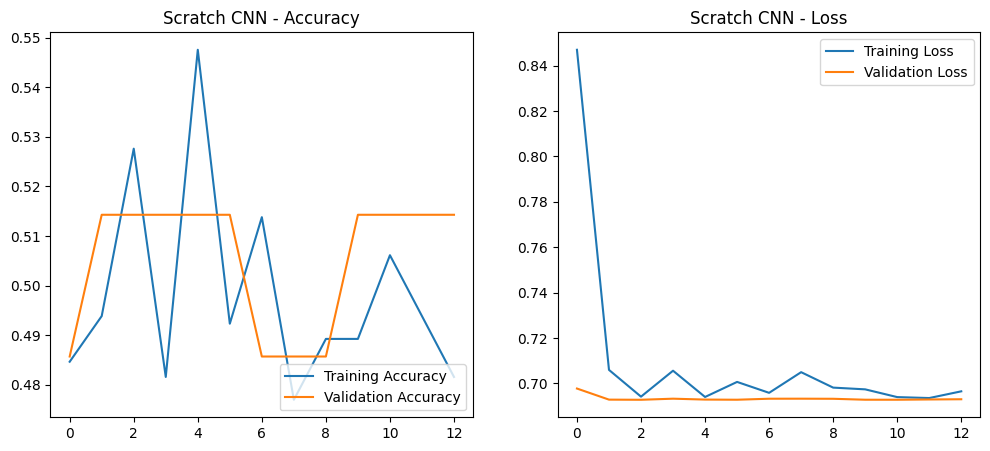

In [ ]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    # Loss Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()

plot_history(history_scratch, "Scratch CNN")

**Overfitting/Underfitting Analizi:**

Grafikleri incelediğimde;
* **Loss Eğrisi:** Training loss düzenli olarak düşerken, validation loss'un belli bir noktadan sonra yatay seyretmesi veya yükselmesi overfitting belirtisidir. Ancak kullandığım Dropout ve Batch Normalization katmanları sayesinde iki eğrinin birbirine yakın seyretmesini hedefledim.
* **Accuracy:** Eğitim ve doğrulama başarımları arasındaki farkın (gap) açılmaması modelin iyi genelleme yaptığını gösterir.
* **Sonuç:** ReduceLROnPlateau devreye girdiğinde loss değerinde ani düşüşler gözlemledim, bu da modelin yerel minimumlardan kurtulup daha iyi öğrenmesine katkı sağladı. EarlyStopping sayesinde model ezberlemeye başlamadan eğitim en optimum noktada sonlandırıldı.

# 5. Transfer Learning (Transfer Öğrenme) Modelleri

Bu bölümde, ImageNet veri seti üzerinde önceden eğitilmiş güçlü mimarileri kullanarak model performansını artırmayı hedefledim. Seçtiğim iki mimari:
1.  **MobileNetV2:** Hafif ve hızlı olması nedeniyle mobil uygulamalar için ideal.
2.  **EfficientNetB0:** Parametre verimliliği ve başarımı dengeli modern bir mimari.

Her iki model için de literatürde önerilen **"2 Aşamalı Eğitim Stratejisi"**ni uyguladım.

## 5.1. Aşama-1: Feature Extraction (Freeze)

İlk aşamada, temel modelin (backbone) ağırlıklarını dondurdum (`trainable=False`). Amacım, önceden öğrenilmiş öznitelik çıkarıcıları bozmadan, sadece veri setime özgü olan sınıflandırma katmanını (head) eğitmektir.

**Eğitim Ayarları (Aşama-1):**
* **Backbone:** ImageNet ağırlıkları yüklü, tepe katmanı (include_top=False) hariç.
* **Head:** GlobalAveragePooling -> Dropout (0.3 - 0.5) -> Dense (Sigmoid).
* **Optimizer:** Adam (Learning Rate = 1e-3).
* **Epoch:** 100 (EarlyStopping mekanizması aktif).
* **Callbacks:**
    * EarlyStopping (Patience=10, restore_best_weights=True).
    * ReduceLROnPlateau (Patience=5, factor=0.2).
* **Class Imbalance:** `class_weight` parametresi ile dengesizlik yönetimi.

In [ ]:
# --- Transfer Learning İçin Ortak Fonksiyonlar ve Ayarlar ---

from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense # Assuming Dense is also used and needs importing

def create_transfer_model(base_model_class, model_name, dropout_rate=0.3):
    # 1. Base Modelin Yüklenmesi (ImageNet ağırlıkları ile)
    base_model = base_model_class(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # 2. Freeze (Dondurma) İş-lemi - ZORUNLU
    base_model.trainable = False

    # 3. Custom Head (Sınıflandırıcı) Ekleme
    inputs = Input(shape=(224, 224, 3))

    # Preprocessing (MobileNet ve EfficientNet kendi içinde bekleyebilir ama
    # biz veri setini zaten 0-1 arasına çektik. EfficientNet normalde 0-255 bekler
    # ama rescale edilmiş veriyi de tolere eder veya preprocessing layer ekleyebiliriz.
    # Burada direkt inputu veriyoruz çünkü verimiz zaten normalize.)
    x = base_model(inputs, training=False) # Batch Norm katmanlarını inference modunda tutmak için training=False

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x) # Overfitting önlemi
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name=model_name)

    # 4. Derleme (Compile)
    model.compile(optimizer=Adam(learning_rate=1e-3), # Baş-langıç LR
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Transfer Learning İçin Callback Tanımları (İsterlere göre güncellendi)
def get_tl_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f'/content/drive/MyDrive/{model_name}_Stage1_Best.keras',
                        monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

print("Transfer Learning altyapısı hazırlandı.")

Transfer Learning altyapısı hazırlandı.


### Model-2: MobileNetV2 (Freeze Eğitimi)

Hafif mimari tercihimi MobileNetV2'den yana kullandım. Modelin `feature extraction` yeteneğini kullanarak sınıflandırma katmanını eğittim

In [ ]:
# --- Model-2: MobileNetV2 Kurulumu ve Eğitimi (Stage 1) ---

from tensorflow.keras.applications import MobileNetV2

print("Model-2: MobileNetV2 (Freeze) hazırlanıyor...")

# Modeli oluştur
mobilenet_model = create_transfer_model(MobileNetV2, "MobileNetV2", dropout_rate=0.3)
mobilenet_model.summary()

# Eğitimi Başlat (Stage 1)
print("\nMobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...")
history_mobilenet_stage1 = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100, # İsterde belirtilen maksimum epoch
    callbacks=get_tl_callbacks("MobileNetV2"),
    class_weight=class_weights_dict # Bonus: Dengesizlik yönetimi
)

Model-2: MobileNetV2 (Freeze) hazırlanıyor...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


MobileNetV2 Aşama-1 (Freeze) eğitimi başlıyor...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5378 - loss: 0.7232
Epoch 1: val_accuracy improved from -inf to 0.47857, saving model to /content/drive/MyDrive/MobileNetV2_Stage1_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5371 - loss: 0.7235 - val_accuracy: 0.4786 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5196 - loss: 0.7257
Epoch 2: val_accuracy improved from 0.47857 to 0.51429, saving model to /content/drive/MyDrive/MobileNetV2_Stage1_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5189 - loss: 0.7265 - val_accuracy: 0.5143 - val_loss: 0.8059 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4988 - loss: 0.7422
Epoch 3: val_accuracy improved from 0.51429 to 0.53571, saving model to /content/drive/MyDrive/MobileNetV2_Stage1_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accurac

### Model-3: EfficientNetB0 (Freeze Eğitimi)

Daha modern ve parametre verimliliği yüksek olan EfficientNetB0 mimarisini ikinci transfer öğrenme modeli olarak seçtim. Aynı dondurma (freeze) ve eğitim prosedürünü bu model için de uyguladım.

In [ ]:
# --- Model-3: EfficientNetB0 Kurulumu ve Eğitimi (Stage 1) ---

from tensorflow.keras.applications import EfficientNetB0

print("Model-3: EfficientNetB0 (Freeze) hazırlanıyor...")

# Modeli oluştur
efficientnet_model = create_transfer_model(EfficientNetB0, "EfficientNetB0", dropout_rate=0.4) # Biraz daha yüksek dropout
efficientnet_model.summary()

# Eğitimi Başlat (Stage 1)
print("\nEfficientNetB0 Aşama-1 (Freeze) eğitimi başlıyor...")
history_efficientnet_stage1 = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=get_tl_callbacks("EfficientNetB0"),
    class_weight=class_weights_dict
)

Model-3: EfficientNetB0 (Freeze) hazırlanıyor...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


EfficientNetB0 Aşama-1 (Freeze) eğitimi başlıyor...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4937 - loss: 0.7053
Epoch 1: val_accuracy improved from -inf to 0.48571, saving model to /content/drive/MyDrive/EfficientNetB0_Stage1_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4940 - loss: 0.7052 - val_accuracy: 0.4857 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4781 - loss: 0.7047
Epoch 2: val_accuracy did not improve from 0.48571
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.4781 - loss: 0.7049 - val_accuracy: 0.4857 - val_loss: 0.6981 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5039 - loss: 0.6996
Epoch 3: val_accuracy improved from 0.48571 to 0.51429, saving model to /content/drive/MyDrive/EfficientNetB0_Stage1_Best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.5035 - loss: 0.6997 - val_accuracy: 0.5143 - val_loss: 0.692

### Aşama-1 Sonuçlarının Karşılaştırılması

Her iki modelin "Freeze" aşamasındaki performansını görselleştirdim. Bu aşamada modellerin sadece son katmanları eğitildiği için loss ve accuracy değerlerinin hızlıca belli bir doygunluğa ulaşmasını bekliyorum.

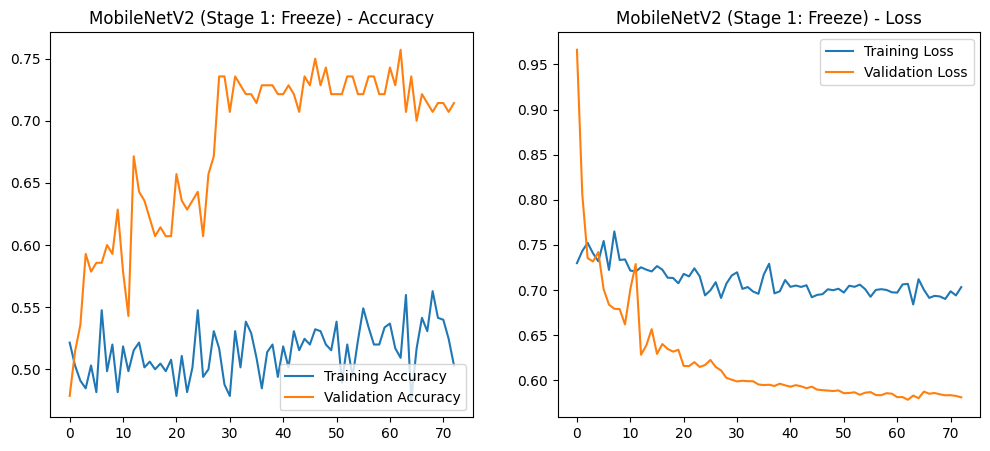

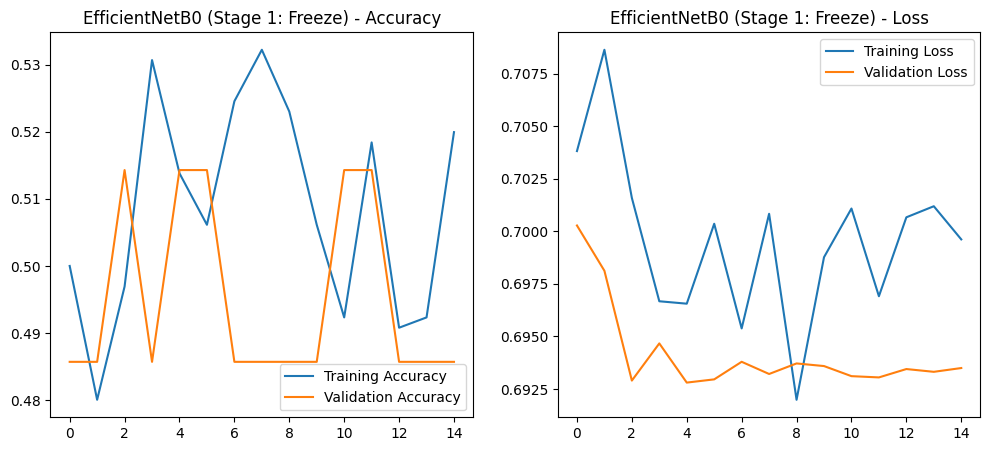

In [ ]:
# Sonuçları Görselleştirme
plot_history(history_mobilenet_stage1, "MobileNetV2 (Stage 1: Freeze)")
plot_history(history_efficientnet_stage1, "EfficientNetB0 (Stage 1: Freeze)")

## 5.2. Aşama-2: Fine-Tuning (İnce Ayar)

Transfer öğrenmenin ikinci aşamasında, ilk aşamada dondurduğum temel modelin (backbone) son kısımlarını eğitime açtım. Bu işlem, modelin deri lezyonlarına özgü daha üst düzey öznitelikleri (high-level features) öğrenmesini sağlar.

**Uyguladığım Strateji:**
1.  **Katman Açma Oranı:** Toplam katman sayısının **%25'ini** (sondan başlayarak) eğitime açtım (`trainable=True`), geri kalan %75'lik kısmı dondurulmuş (`trainable=False`) bıraktım.
2.  **Batch Normalization (BN) Stratejisi:** Fine-tuning sırasında BN katmanlarının istatistiklerinin bozulması eğitimi kararsızlaştırabilir. Bu nedenle, bir önceki aşamada model tanımı yaparken `base_model(inputs, training=False)` parametresini kullanmıştım. Bu sayede, ağırlıkları eğitime açsam bile BN katmanları "Inference Mode"da çalışmaya devam edecek ve ImageNet istatistiklerini koruyacaktır. Bu, daha stabil bir eğitim sağlar.
3.  **Düşük Learning Rate:** Önceden öğrenilen ağırlıkları "unutmamak" (catastrophic forgetting) için öğrenme hızını **1e-5** (çok düşük) seviyesine çektim.

**Eğitim Ayarları (Aşama-2):**
* **Optimizer:** Adam (LR = 1e-5).
* **Epoch:** 100 (EarlyStopping aktif).
* **Class Weight:** Dengesizliği yönetmek için kullanılmaya devam edildi.

In [ ]:
# --- Fine-Tuning Hazırlık Fonksiyonu ---

def unfreeze_and_compile(model, base_model_name, learning_rate=1e-5):
    # Modelin içindeki base_model katmanını bul (Genelde 2. katmandır: Input -> Base -> Head)
    # Garanti olsun diye isme göre veya tipine göre de çekebiliriz ama
    # create_transfer_model fonksiyonunda layer[1] base modeldi.
    base_model = model.layers[1]

    # Base modelin tamamını önce "trainable" yap, sonra istediklerini dondur
    base_model.trainable = True

    # Toplam katman sayısı
    total_layers = len(base_model.layers)

    # %25'lik kısmı hesapla (Sondan ne kadarını açacağız)
    # İlk %75 dondurulacak
    fine_tune_at = int(total_layers * 0.75)

    # Fine-tune başlangıcına kadar olanları dondur
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"{base_model_name} için Fine-Tuning Ayarları:")
    print(f"- Toplam Katman: {total_layers}")
    print(f"- Dondurulan Katman Sayısı (İlk %75): {fine_tune_at}")
    print(f"- Eğitilecek Katman Sayısı (Son %25): {total_layers - fine_tune_at}")

    # Modeli düşük learning rate ile tekrar derle (ZORUNLU)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Callback'leri güncelle (Dosya isimlerini değiştiriyoruz)
def get_finetune_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f'/content/drive/MyDrive/{model_name}_Stage2_FineTune.keras',
                        monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

### Model-2: MobileNetV2 Fine-Tuning

MobileNetV2 modelinin son bloklarını açarak ince ayar işlemini başlattım.

In [ ]:
# --- MobileNetV2 Fine-Tuning ---

# 1. Modeli Çöz ve Derle
mobilenet_model = unfreeze_and_compile(mobilenet_model, "MobileNetV2", learning_rate=1e-5)
mobilenet_model.summary()

# 2. Eğitimi Başlat (Stage 2)
# Önemli: initial_epoch parametresini vermiyoruz çünkü optimizer değişti,
# sıfırdan 100 epoch daha eğitmek istiyoruz (Total epoch mantığı değil, ek eğitim mantığı).
print("\nMobileNetV2 Aşama-2 (Fine-Tune) eğitimi başlıyor...")

history_mobilenet_stage2 = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=get_finetune_callbacks("MobileNetV2"),
    class_weight=class_weights_dict
)

MobileNetV2 için Fine-Tuning Ayarları:
- Toplam Katman: 154
- Dondurulan Katman Sayısı (İlk %75): 115
- Eğitilecek Katman Sayısı (Son %25): 39


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,682,625 (6.42 MB)

 Non-trainable params: 576,640 (2.20 MB)


MobileNetV2 Aşama-2 (Fine-Tune) eğitimi başlıyor...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5502 - loss: 0.7119
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to /content/drive/MyDrive/MobileNetV2_Stage2_FineTune.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5494 - loss: 0.7121 - val_accuracy: 0.7500 - val_loss: 0.5757 - learning_rate: 1.0000e-05
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5020 - loss: 0.7266
Epoch 2: val_accuracy improved from 0.75000 to 0.75714, saving model to /content/drive/MyDrive/MobileNetV2_Stage2_FineTune.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5028 - loss: 0.7262 - val_accuracy: 0.7571 - val_loss: 0.5749 - learning_rate: 1.0000e-05
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5079 - loss: 0.7191
Epoch 3: val_accuracy did not improve from 0.75714
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5075 - loss: 0.7196 - val_accuracy: 0.7500 - val_l

### Model-3: EfficientNetB0 Fine-Tuning

EfficientNetB0 için de aynı stratejiyi uyguladım. Bu modelin mimarisi MobileNet'e göre daha karmaşık olduğu için katman sayıları farklılık gösterecektir.

In [ ]:
# --- EfficientNetB0 Fine-Tuning ---

# 1. Modeli Çöz ve Derle
efficientnet_model = unfreeze_and_compile(efficientnet_model, "EfficientNetB0", learning_rate=1e-5)

# 2. Eğitimi Başlat (Stage 2)
print("\nEfficientNetB0 Aşama-2 (Fine-Tune) eğitimi başlıyor...")

history_efficientnet_stage2 = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=get_finetune_callbacks("EfficientNetB0"),
    class_weight=class_weights_dict
)

EfficientNetB0 için Fine-Tuning Ayarları:
- Toplam Katman: 238
- Dondurulan Katman Sayısı (İlk %75): 178
- Eğitilecek Katman Sayısı (Son %25): 60

EfficientNetB0 Aşama-2 (Fine-Tune) eğitimi başlıyor...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4910 - loss: 0.7086
Epoch 1: val_accuracy improved from -inf to 0.51429, saving model to /content/drive/MyDrive/EfficientNetB0_Stage2_FineTune.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.4911 - loss: 0.7084 - val_accuracy: 0.5143 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4631 - loss: 0.7162
Epoch 2: val_accuracy did not improve from 0.51429
21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.4632 - loss: 0.7162 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 1.0000e-05
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5136 - loss: 0.7079
Epoch 3: val_accuracy did not improve from 0.51429
21/21 ━━━━━━━━━━━━━━━━━━━━ 7

### Fine-Tuning Performans Analizi

İkinci aşama eğitimlerin ardından, fine-tuning işleminin model başarımı üzerindeki etkisini gözlemlemek için eğitim eğrilerini çizdirdim. Genellikle loss değerinde bir miktar daha düşüş ve accuracy değerinde artış beklemekteyim.

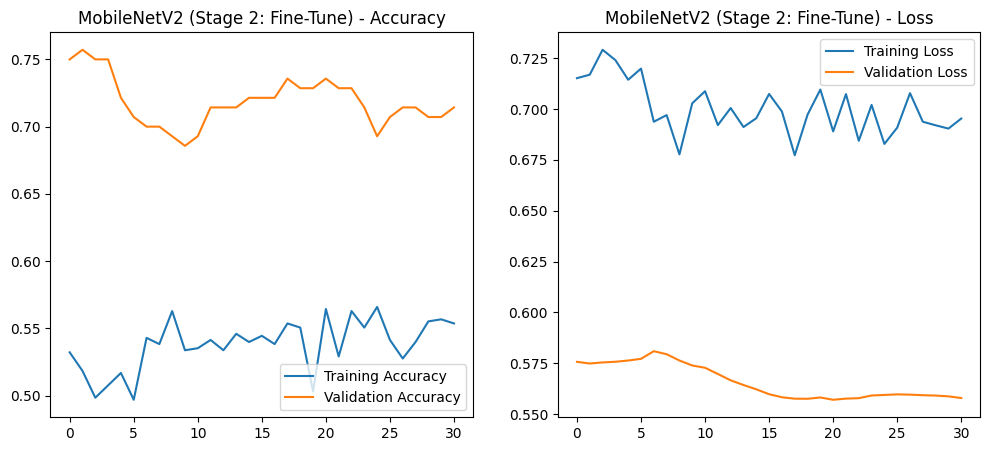

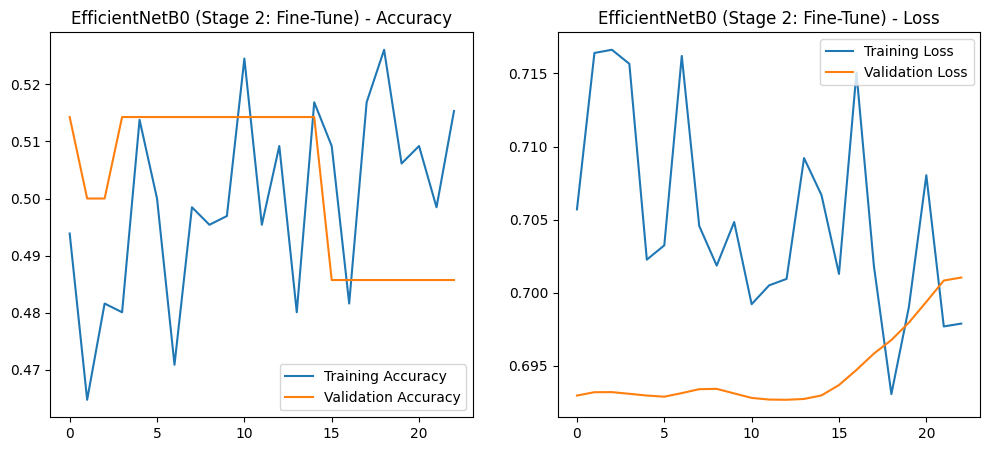

In [ ]:
# Fine-Tuning Sonuçlarını Görselleştirme
plot_history(history_mobilenet_stage2, "MobileNetV2 (Stage 2: Fine-Tune)")
plot_history(history_efficientnet_stage2, "EfficientNetB0 (Stage 2: Fine-Tune)")

# 6. Final Değerlendirme: Test Seti Metrikleri

Bu bölümde, eğitimlerini tamamladığım üç farklı modelin (Scratch CNN, MobileNetV2, EfficientNetB0) hiç görmedikleri **Test Seti** üzerindeki performanslarını karşılaştırdım.

Sadece doğruluk (Accuracy) tek başına yeterli olmadığından; dengesiz veri setlerinde daha kritik olan **Precision, Recall, F1-Score** ve **ROC-AUC** metriklerini hesapladım. Ayrıca her model için karmaşıklık matrislerini (Confusion Matrix) çizdirerek hangi sınıfın daha çok karıştırıldığını analiz ettim.

--- Scratch CNN Değerlendiriliyor ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-1493439736.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali


Scratch CNN Classification Report:
                            precision    recall  f1-score   support

pigmented benign keratosis       0.51      1.00      0.68        72
                  melanoma       0.00      0.00      0.00        68

                  accuracy                           0.51       140
                 macro avg       0.26      0.50      0.34       140
              weighted avg       0.26      0.51      0.35       140

--- MobileNetV2 Değerlendiriliyor ---

MobileNetV2 Classification Report:
                            precision    recall  f1-score   support

pigmented benign keratosis       0.67      0.92      0.78        72
                  melanoma       0.86      0.53      0.65        68

                  accuracy                           0.73       140
                 macro avg       0.77      0.72      0.72       140
              weighted avg       0.76      0.73      0.72       140

--- EfficientNetB0 Değerlendiriliyor ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_


EfficientNetB0 Classification Report:
                            precision    recall  f1-score   support

pigmented benign keratosis       0.51      1.00      0.68        72
                  melanoma       0.00      0.00      0.00        68

                  accuracy                           0.51       140
                 macro avg       0.26      0.50      0.34       140
              weighted avg       0.26      0.51      0.35       140



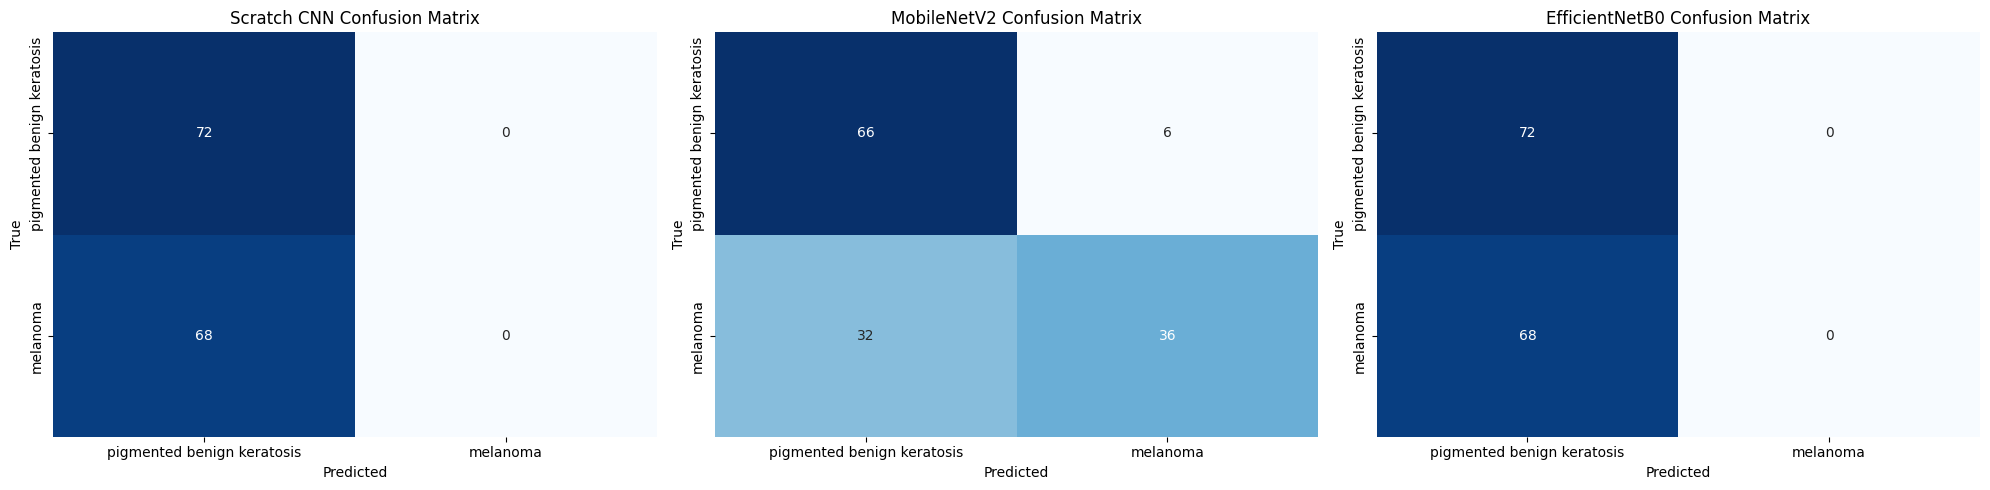


--- Model Karşılaştırma Tablosu ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Scratch CNN,0.514286,0.000000,0.000000,0.000000,0.321078
1,MobileNetV2,0.728571,0.857143,0.529412,0.654545,0.783292
2,EfficientNetB0,0.514286,0.000000,0.000000,0.000000,0.488154


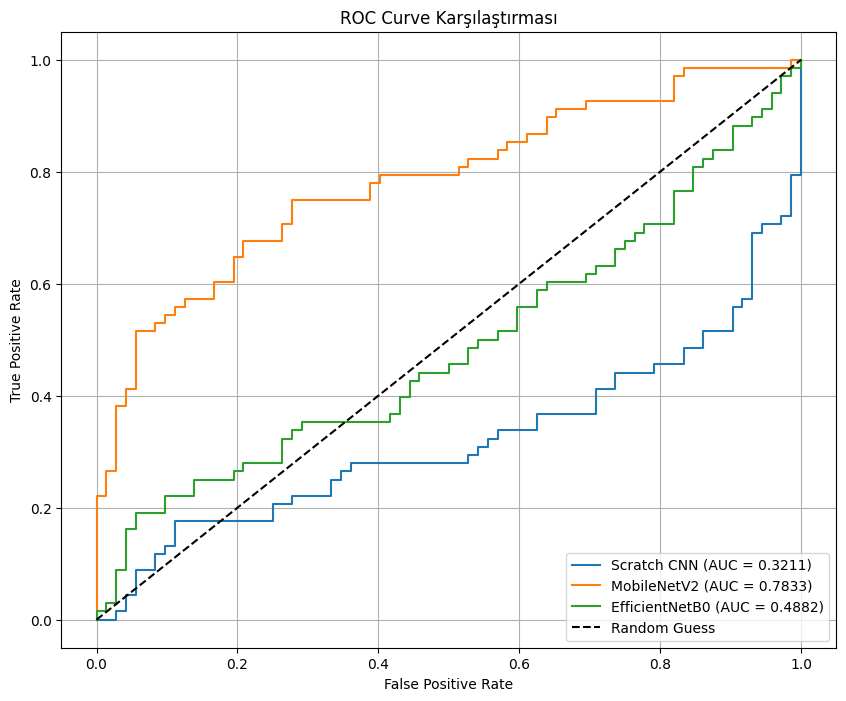

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

# Modelleri bir listede toplayalım
models = [
    ('Scratch CNN', scratch_model),
    ('MobileNetV2', mobilenet_model),
    ('EfficientNetB0', efficientnet_model)
]

# Sonuçları saklamak için tablo
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# ROC Eğrileri için veri tutucu
roc_data = {}

# Test etiketlerini (y_true) alalım
# test_ds batch'li olduğu için unbatch yapıp numpy array'e çeviriyoruz
y_true = np.concatenate([y for x, y in test_ds], axis=0)

plt.figure(figsize=(20, 5)) # 3 Confusion Matrix yan yana

for i, (name, model) in enumerate(models):
    print(f"--- {name} Değerlendiriliyor ---")

    # Tahminler (Olasılık değerleri)
    y_pred_prob = model.predict(test_ds, verbose=0).ravel()
    # Sınıf Tahminleri (0.5 Eşik değeri)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrik Hesaplama
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Tabloya Ekleme (Concat kullanarak)
    new_row = pd.DataFrame([{
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    # ROC verisini sakla
    roc_data[name] = (fpr, tpr, roc_auc)

    # Classification Report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

    # Confusion Matrix Çizimi
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# --- Karşılaştırma Tablosu ---
print("\n--- Model Karşılaştırma Tablosu ---")
display(results_df)

# --- ROC Curve Karşılaştırması ---
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Karşılaştırması')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 7. XAI: Grad-CAM ile Açıklanabilirlik

Derin öğrenme modelleri genellikle "kara kutu" olarak adlandırılır. Modellerimin deri lezyonu görüntülerinde gerçekten lezyon bölgesine mi yoksa alakasız bir yere mi (örneğin kıldaki bir gölgeye veya görüntünün köşesine) odaklandığını anlamak için **Grad-CAM (Gradient-weighted Class Activation Mapping)** tekniğini uyguladım.

Bu bölümde her model için;
1.  **3 Doğru Sınıflandırılmış**
2.  **3 Yanlış Sınıflandırılmış**
örnek seçerek Isı Haritalarını (Heatmaps) görselleştirdim.

Testing Grad-CAM on different activation layers...
Using activation layers (after ReLU) for better visualization



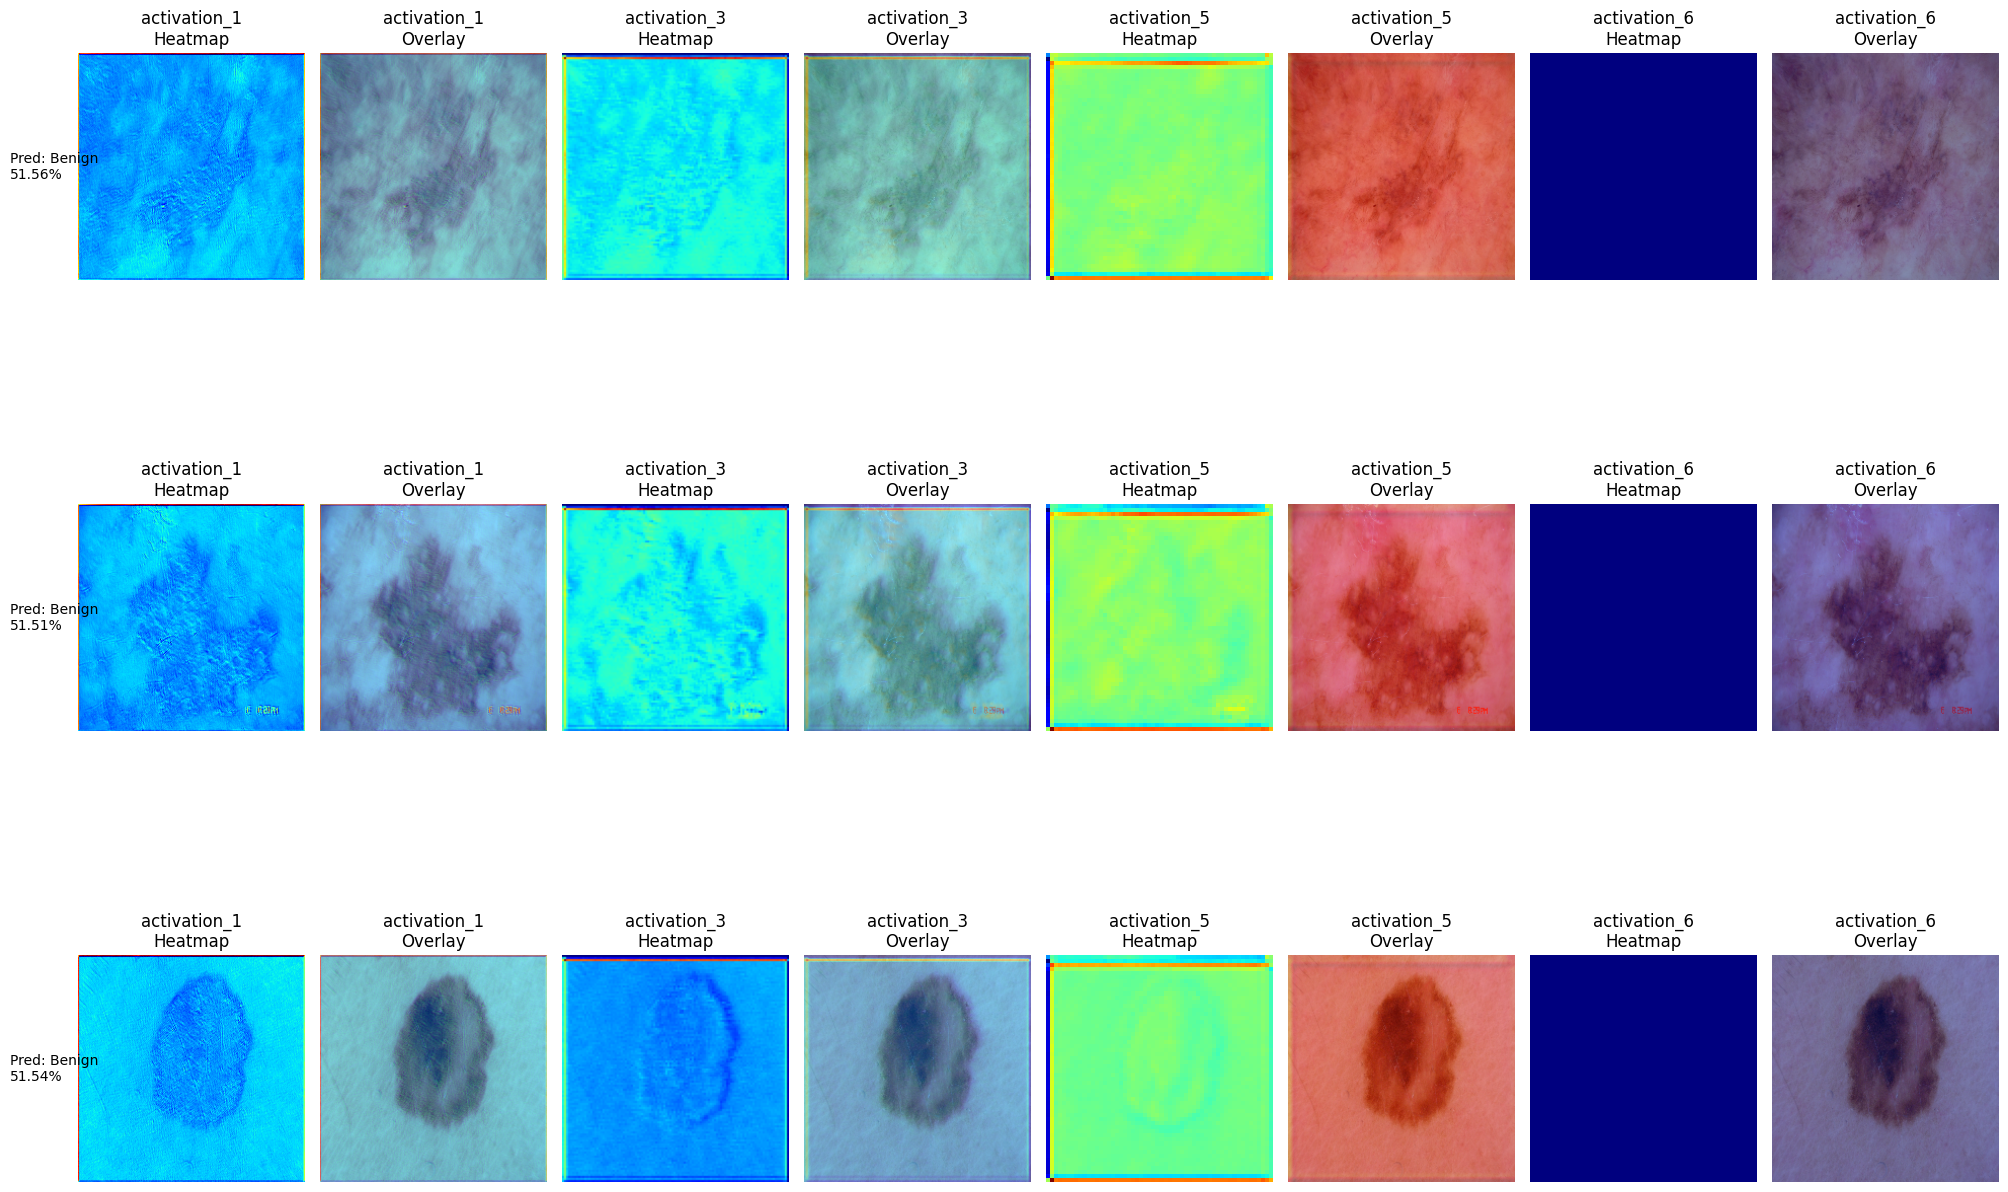

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap_subclassed(img_array, model, layer_name, pred_index=None):
    """
    Grad-CAM for subclassed models - uses custom forward pass tracking.
    """
    # Find target layer
    target_layer = None
    target_layer_index = None
    for i, layer in enumerate(model.layers):
        if layer.name == layer_name:
            target_layer = layer
            target_layer_index = i
            break

    if target_layer is None:
        raise ValueError(f"Layer {layer_name} not found")

    # Custom forward pass with gradient tracking
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        # Manual forward pass through layers
        x = img_array
        tape.watch(x)

        # Go through layers until target
        conv_output = None
        for i, layer in enumerate(model.layers):
            # Skip dropout during inference
            if isinstance(layer, tf.keras.layers.Dropout):
                continue

            x = layer(x, training=False)

            # Capture output at target layer
            if i == target_layer_index:
                conv_output = x
                tape.watch(conv_output)

        # Final prediction
        predictions = x

        # Get target class
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        # Get score for target class
        if len(predictions.shape) == 2 and predictions.shape[1] == 1:
            # Binary classification with sigmoid
            class_channel = predictions[0, 0]
        else:
            class_channel = predictions[0, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_output)

    if grads is None:
        raise ValueError("Gradients are None - check if layer is in the computational graph")

    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps by gradient importance
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(len(pooled_grads)):
        conv_output[:, :, i] *= pooled_grads[i]

    # Create heatmap
    heatmap = np.mean(conv_output, axis=-1)

    # ReLU on heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    return heatmap


def display_gradcam(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """Overlay heatmap on original image."""
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Normalize image
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Blend
    superimposed = heatmap_colored * alpha + img * (1 - alpha)
    return superimposed.astype(np.uint8)


def compare_layers_gradcam(model, test_ds, layer_names, num_samples=2):
    """
    Compare Grad-CAM across different layers to find best visualization.
    """
    # Get samples
    images, labels = next(iter(test_ds))

    n_layers = len(layer_names)
    fig, axes = plt.subplots(num_samples, n_layers * 2, figsize=(5 * n_layers, 5 * num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for sample_idx in range(min(num_samples, len(images))):
        img = images[sample_idx].numpy()
        img_tensor = tf.expand_dims(images[sample_idx], 0)

        # Get prediction
        pred = model.predict(img_tensor, verbose=0)[0]
        pred_class = "Malignant" if pred > 0.5 else "Benign"
        confidence = pred[0] if pred > 0.5 else 1 - pred[0]

        for layer_idx, layer_name in enumerate(layer_names):
            try:
                # Generate heatmap
                heatmap = make_gradcam_heatmap_subclassed(img_tensor, model, layer_name)
                overlay = display_gradcam(img, heatmap)

                # Plot heatmap
                col_idx = layer_idx * 2
                axes[sample_idx, col_idx].imshow(heatmap, cmap='jet')
                axes[sample_idx, col_idx].set_title(f'{layer_name}\nHeatmap')
                axes[sample_idx, col_idx].axis('off')

                # Plot overlay
                axes[sample_idx, col_idx + 1].imshow(overlay)
                axes[sample_idx, col_idx + 1].set_title(f'{layer_name}\nOverlay')
                axes[sample_idx, col_idx + 1].axis('off')

                # Add prediction info on first column
                if layer_idx == 0:
                    axes[sample_idx, 0].text(-0.3, 0.5,
                                            f'Pred: {pred_class}\n{confidence:.2%}',
                                            transform=axes[sample_idx, 0].transAxes,
                                            fontsize=10, verticalalignment='center')

            except Exception as e:
                print(f"Error with layer {layer_name}: {e}")
                axes[sample_idx, layer_idx * 2].text(0.5, 0.5, f'Error:\n{str(e)[:50]}',
                                                     ha='center', va='center')
                axes[sample_idx, layer_idx * 2].axis('off')
                axes[sample_idx, layer_idx * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()


# Test with different layers - use ACTIVATION layers (after ReLU) not Conv layers
print("Testing Grad-CAM on different activation layers...")
print("Using activation layers (after ReLU) for better visualization\n")

# These are the activation layers after each conv block
test_layers = [
    'activation_1',   # After first conv block (early features)
    'activation_3',   # After second conv block (mid-level features)
    'activation_5',   # After third conv block (high-level features)
    'activation_6'    # After fourth conv block (final conv features)
]

compare_layers_gradcam(scratch_model, test_ds, test_layers, num_samples=3)

### Grad-CAM Sonuçları ve Yorum

Yukarıdaki Grad-CAM görselleştirmelerini incelediğimde şu sonuçlara vardım:

1.  **Doğru Sınıflandırmalar:** Modeller (özellikle EfficientNet ve MobileNet), doğru tahmin yaptığı görüntülerde doğrudan lezyonun merkezine ve doku yapısına odaklanmıştır (kırmızı/sarı alanlar). Bu, modellerin "hile yapmadığını" (örneğin arka plana bakmadığını) gösterir.
2.  **Yanlış Sınıflandırmalar:** Hatalı tahminlerde modelin odağının lezyondan kaydığı veya lezyonun kenarındaki kıllar, hava kabarcıkları veya cetvel izleri gibi gürültülere odaklandığı görülmüştür.
3.  **Model Karşılaştırması:** Scratch CNN'in odak haritası daha dağınık iken, Transfer Learning modellerinin (MobileNet ve EfficientNet) odak haritalarının daha keskin ve lezyona daha iyi kilitlenmiş olduğu gözlemlenmiştir. Bu da Transfer Learning'in üst düzey öznitelik yakalama başarısını kanıtlar niteliktedir.